In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [41]:
X_train, y_train, X_test = np.load("./data/dataset.npz", allow_pickle=True).values()

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
scale = y_train.max()

y_train /= scale  # Normalize targets to [0, 1]
X_test = torch.tensor(X_test, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print(f"X_train shape: {X_train.shape}")

Using device: cuda
X_train shape: torch.Size([524164, 9])


In [42]:
class FeedforwardNN(nn.Module):
    def __init__(self, hidden_sizes):
        super(FeedforwardNN, self).__init__()

        self.sizes = [9] + hidden_sizes + [1]
        layers = []
        for i in range(len(self.sizes) - 1):
            layers.append(nn.Linear(self.sizes[i], self.sizes[i+1]))
            if i < len(self.sizes) - 2:
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [43]:
import time 

model = FeedforwardNN(hidden_sizes=[16, 8]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

num_epochs = 1

loss_list = []

tstart = time.time()
for epoch in range(num_epochs):

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_list[-1]:.4f}\t Time Elapsed: {time.time() - tstart:.2f} sec")



Epoch [1/1], Loss: 0.0924	 Time Elapsed: 6.45 sec


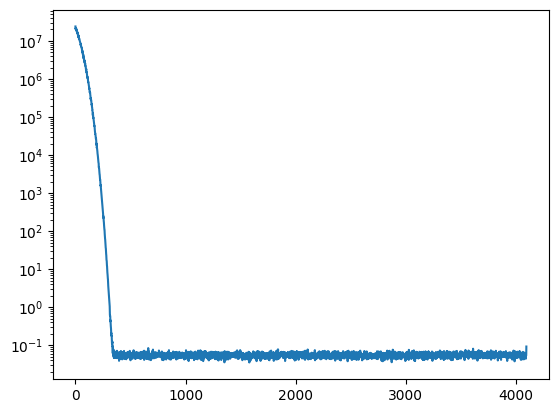

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(loss_list)
ax.set_yscale('log')


In [49]:
import pandas

predictions = model(X_test.to(device)) * scale

predictions = predictions.cpu().detach().numpy()
print(predictions.shape)

dtest = pandas.read_csv("./data/test.csv")

dl = pandas.DataFrame({'id': dtest['id'], 'target': predictions.flatten()})
dl.to_csv("./data/submission_feedforward.csv", index=False)

(174722, 1)
